In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


/home/nati/.virtualenvs/cosmogan-py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [3]:
ns = 32
try_resume = False
Mpch=70

In [4]:
def forward(X):
    return np.log(np.sqrt(X)+np.e)-2

def backward(Xmap, max_value=2e5):
    Xmap = np.clip(Xmap, -1.0, forward(max_value))
    tmp = np.exp((Xmap+2))-np.e
    return np.round(tmp*tmp)

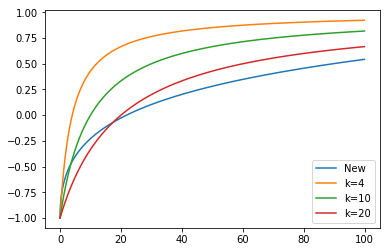

In [6]:
x = np.arange(0,100,0.1)
import fmap
plt.plot(x,forward(x))
plt.plot(x,fmap.forward_map(x,k=4))
plt.plot(x,fmap.forward_map(x,k=10))
plt.plot(x,fmap.forward_map(x,k=20))
plt.legend(['New','k=4','k=10','k=20'])

# Data handling

Load the data

In [7]:
dataset = data.load.load_dataset(spix=ns, resolution=256,Mpch=Mpch, forward_map=forward)

In [8]:
dataset.get_all_data().shape

(163840, 32, 32)

min: -1.0
max: 4.019108772277832


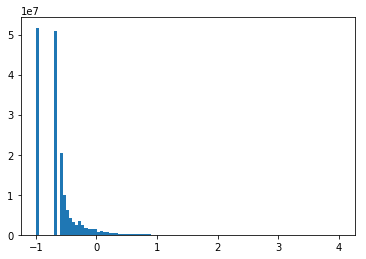

In [9]:
X = dataset.get_all_data()
nel = np.prod(X.shape)
Xvec = np.reshape(X,[nel])
hist(Xvec, 100)
print('min: {}'.format(min(Xvec)))
print('max: {}'.format(max(Xvec)))

Let us plot 16 images

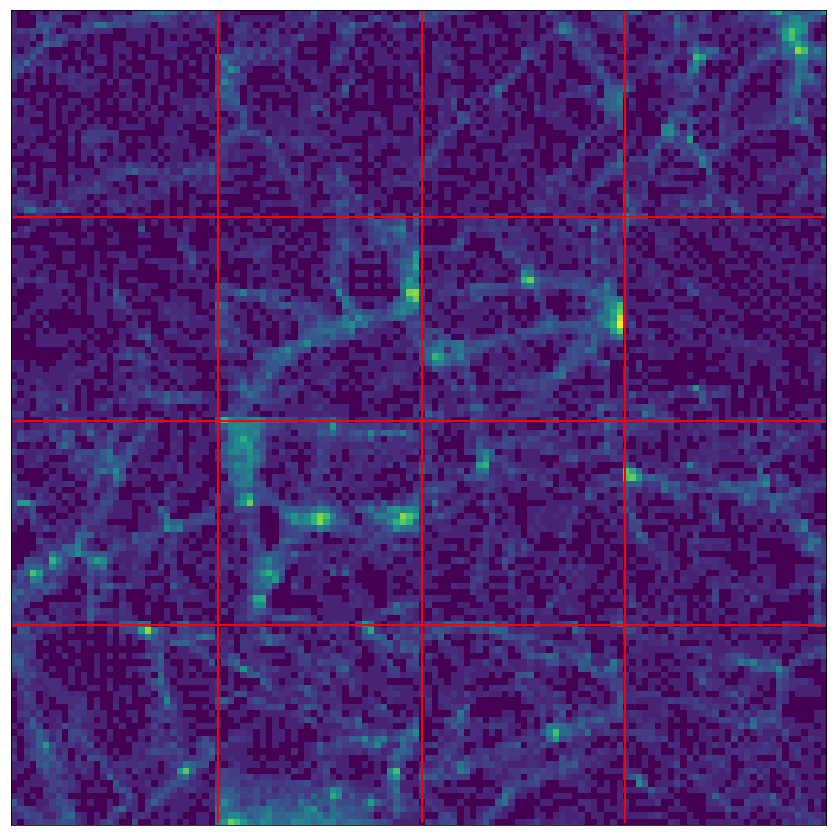

In [10]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [11]:
time_str = 'test_{}'.format(Mpch)
global_path = '../../saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [13]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = None

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 5


params_cosmology = dict()
params_cosmology['clip_max_real'] = True
params_cosmology['log_clip'] = 0.1
params_cosmology['sigma_smooth'] = 1
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward
params_cosmology['Npsd'] = 500


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'_summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + '_checkpoints/'

In [14]:
resume, params = utils.test_resume(try_resume, params)

## Build the model

In [15]:
wgan = CosmoGAN(params, WGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 16, 16, 32)
     1 Deconv layer with 32 channels
         Size of the variables: (?, 32, 32, 32)
     2 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
     The output is of size (?, 32, 32, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 32, 32, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 8, 8, 32)
     2 Conv layer with 32 channels
         Size of the variables: (?, 4, 4, 32)
     Reshape to (?, 512)
     3 Full layer with 32 outputs
     

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [16]:
wgan.train(dataset, resume=resume)

Erase recursively directory: ../../saved_result/WGAN32_test_70_summary/
Erase recursively directory: ../../saved_result/WGAN32_test_70_checkpoints/
Epoch: [ 0] [  99/10240] Counter:100	( 0.2 min	171.456 examples/sec	0.09 sec/batch)	L_Disc:-0.01938287	L_Gen:-0.78614902
Epoch: [ 0] [ 199/10240] Counter:200	( 0.2 min	314.625 examples/sec	0.05 sec/batch)	L_Disc:-0.00323025	L_Gen:-1.56916904
Epoch: [ 0] [ 299/10240] Counter:300	( 0.3 min	313.596 examples/sec	0.05 sec/batch)	L_Disc:-0.60087001	L_Gen:0.86875606
Epoch: [ 0] [ 399/10240] Counter:400	( 0.4 min	312.465 examples/sec	0.05 sec/batch)	L_Disc:-1.02481651	L_Gen:0.25148195
Epoch: [ 0] [ 499/10240] Counter:500	( 0.5 min	313.988 examples/sec	0.05 sec/batch)	L_Disc:-1.14244258	L_Gen:-0.51734948
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.362,1.150],	Mean [2.177E+00,6.514E+00],	Max [1.675E+01,9.860E+02],	Var [6.370E+00,7.963E+03]
 [*] [Comp, Fake, Real] PeakDistance:[2.304, 1.312, 3.271]	CrossPS:[4.349, 60.139, 1.775]
 [*] New PSD Low a

Epoch: [ 0] [4099/10240] Counter:4100	( 5.2 min	107.615 examples/sec	0.15 sec/batch)	L_Disc:-0.33269802	L_Gen:-0.23422503
Epoch: [ 0] [4199/10240] Counter:4200	( 5.3 min	247.699 examples/sec	0.06 sec/batch)	L_Disc:-0.22184333	L_Gen:-0.84712088
Epoch: [ 0] [4299/10240] Counter:4300	( 5.4 min	315.463 examples/sec	0.05 sec/batch)	L_Disc:-0.21396227	L_Gen:-1.13782024
Epoch: [ 0] [4399/10240] Counter:4400	( 5.4 min	311.884 examples/sec	0.05 sec/batch)	L_Disc:-0.28097400	L_Gen:-1.71925128
Epoch: [ 0] [4499/10240] Counter:4500	( 5.5 min	319.337 examples/sec	0.05 sec/batch)	L_Disc:-0.21447581	L_Gen:-1.14876974
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.091,1.201],	Mean [5.064E+00,7.351E+00],	Max [2.641E+02,1.169E+03],	Var [2.025E+03,2.479E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.043, 0.909, 3.367]	CrossPS:[-1.036, 1.949, 2.872]
 [*] New PSD Low achieved 361717.875094 (was 373860.570032)
 [*] New Log PSD Low achieved 39.838170 (was 48.656786)
 4500 current PSD L2 361717.8750938173, log

Epoch: [ 0] [8399/10240] Counter:8400	(10.4 min	314.589 examples/sec	0.05 sec/batch)	L_Disc:-0.27629647	L_Gen:-0.86848086
Epoch: [ 0] [8499/10240] Counter:8500	(10.5 min	311.722 examples/sec	0.05 sec/batch)	L_Disc:-0.11724363	L_Gen:0.26082569
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.530,1.378],	Mean [6.708E+00,9.393E+00],	Max [4.191E+02,1.546E+03],	Var [2.586E+03,2.929E+04]
 [*] [Comp, Fake, Real] PeakDistance:[2.931, 0.993, 2.874]	CrossPS:[0.969, 0.728, -4.880]
 8500 current PSD L2 338206.7960372518, logL2 26.74128832461147
Epoch: [ 0] [8599/10240] Counter:8600	(10.7 min	107.796 examples/sec	0.15 sec/batch)	L_Disc:-0.35134804	L_Gen:0.02710838
Epoch: [ 0] [8699/10240] Counter:8700	(10.8 min	246.055 examples/sec	0.07 sec/batch)	L_Disc:-0.41614449	L_Gen:1.22713411
Epoch: [ 0] [8799/10240] Counter:8800	(10.9 min	312.837 examples/sec	0.05 sec/batch)	L_Disc:-0.31101677	L_Gen:-0.27155975
Epoch: [ 0] [8899/10240] Counter:8900	(11.0 min	313.408 examples/sec	0.05 sec/batch)	L_Disc:-0.367

Epoch: [ 1] [2559/10240] Counter:12800	(15.9 min	247.969 examples/sec	0.06 sec/batch)	L_Disc:-0.38681272	L_Gen:1.95953763
Epoch: [ 1] [2659/10240] Counter:12900	(16.0 min	315.393 examples/sec	0.05 sec/batch)	L_Disc:-0.29568851	L_Gen:-0.12419407
Epoch: [ 1] [2759/10240] Counter:13000	(16.1 min	312.702 examples/sec	0.05 sec/batch)	L_Disc:-0.29092324	L_Gen:0.13082276
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.650,1.209],	Mean [4.348E+00,7.619E+00],	Max [3.773E+02,1.148E+03],	Var [2.122E+03,1.447E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.063, 1.023, 3.949]	CrossPS:[0.543, 2.266, 1.826]
 [*] New Log PSD Low achieved 13.019309 (was 18.580761)
 13000 current PSD L2 187837.24096396234, logL2 13.019308754262175
Model saved!
Epoch: [ 1] [2859/10240] Counter:13100	(16.3 min	102.353 examples/sec	0.16 sec/batch)	L_Disc:-0.31119743	L_Gen:0.80174983
Epoch: [ 1] [2959/10240] Counter:13200	(16.5 min	248.716 examples/sec	0.06 sec/batch)	L_Disc:-0.17243022	L_Gen:1.75631797
Epoch: [ 1] [3059/10240

Epoch: [ 1] [6959/10240] Counter:17200	(21.5 min	249.175 examples/sec	0.06 sec/batch)	L_Disc:-0.30242994	L_Gen:-0.14091212
Epoch: [ 1] [7059/10240] Counter:17300	(21.5 min	312.947 examples/sec	0.05 sec/batch)	L_Disc:-0.26451406	L_Gen:0.60269761
Epoch: [ 1] [7159/10240] Counter:17400	(21.6 min	311.609 examples/sec	0.05 sec/batch)	L_Disc:-0.23920856	L_Gen:1.38281631
Epoch: [ 1] [7259/10240] Counter:17500	(21.7 min	314.510 examples/sec	0.05 sec/batch)	L_Disc:-0.21000689	L_Gen:1.19341230
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.955,1.214],	Mean [4.901E+00,7.977E+00],	Max [4.027E+02,1.317E+03],	Var [1.262E+04,1.712E+04]
 [*] [Comp, Fake, Real] PeakDistance:[2.746, 0.646, 3.101]	CrossPS:[-1.180, -2.377, 0.798]
 17500 current PSD L2 393733.9793466059, logL2 25.174593687447544
Epoch: [ 1] [7359/10240] Counter:17600	(22.0 min	105.377 examples/sec	0.15 sec/batch)	L_Disc:-0.24771068	L_Gen:1.14463687
Epoch: [ 1] [7459/10240] Counter:17700	(22.1 min	250.880 examples/sec	0.06 sec/batch)	L_Dis

Epoch: [ 2] [1319/10240] Counter:21800	(27.2 min	315.603 examples/sec	0.05 sec/batch)	L_Disc:-0.24606182	L_Gen:0.63703007
Epoch: [ 2] [1419/10240] Counter:21900	(27.3 min	318.823 examples/sec	0.05 sec/batch)	L_Disc:-0.18750249	L_Gen:1.11185789
Epoch: [ 2] [1519/10240] Counter:22000	(27.4 min	315.179 examples/sec	0.05 sec/batch)	L_Disc:-0.15049899	L_Gen:0.33667761
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.843,1.189],	Mean [4.020E+00,7.566E+00],	Max [2.244E+02,1.130E+03],	Var [6.084E+02,1.596E+04]
 [*] [Comp, Fake, Real] PeakDistance:[2.717, 0.817, 2.907]	CrossPS:[-0.614, 5.209, 5.108]
 22000 current PSD L2 405479.1383485245, logL2 28.46522185532503
Model saved!
Epoch: [ 2] [1619/10240] Counter:22100	(27.7 min	94.448 examples/sec	0.17 sec/batch)	L_Disc:-0.20095763	L_Gen:0.24258114
Epoch: [ 2] [1719/10240] Counter:22200	(27.7 min	314.046 examples/sec	0.05 sec/batch)	L_Disc:-0.18017039	L_Gen:1.54379880
Epoch: [ 2] [1819/10240] Counter:22300	(27.8 min	313.368 examples/sec	0.05 sec/bat

Epoch: [ 2] [5819/10240] Counter:26300	(32.9 min	312.832 examples/sec	0.05 sec/batch)	L_Disc:-0.01103066	L_Gen:1.13188267
Epoch: [ 2] [5919/10240] Counter:26400	(32.9 min	314.534 examples/sec	0.05 sec/batch)	L_Disc:-0.13482913	L_Gen:1.24916530
Epoch: [ 2] [6019/10240] Counter:26500	(33.0 min	312.839 examples/sec	0.05 sec/batch)	L_Disc:0.02062718	L_Gen:1.25447714
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.854,1.245],	Mean [6.473E+00,7.685E+00],	Max [4.690E+02,1.223E+03],	Var [1.315E+04,1.518E+04]
 [*] [Comp, Fake, Real] PeakDistance:[4.061, 1.276, 4.403]	CrossPS:[-0.719, 0.397, 10.525]
 26500 current PSD L2 284751.04618223134, logL2 22.82335673775447
Epoch: [ 2] [6119/10240] Counter:26600	(33.3 min	94.186 examples/sec	0.17 sec/batch)	L_Disc:-0.11035838	L_Gen:0.96349907
Epoch: [ 2] [6219/10240] Counter:26700	(33.4 min	316.664 examples/sec	0.05 sec/batch)	L_Disc:-0.10089825	L_Gen:0.87782860
Epoch: [ 2] [6319/10240] Counter:26800	(33.5 min	312.107 examples/sec	0.05 sec/batch)	L_Disc:-

Epoch: [ 3] [ 179/10240] Counter:30900	(38.6 min	313.744 examples/sec	0.05 sec/batch)	L_Disc:-0.20806172	L_Gen:2.11761737
Epoch: [ 3] [ 279/10240] Counter:31000	(38.7 min	314.091 examples/sec	0.05 sec/batch)	L_Disc:-0.06869169	L_Gen:2.23295760
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.247,1.214],	Mean [5.657E+00,7.176E+00],	Max [3.552E+02,9.804E+02],	Var [2.387E+03,8.824E+03]
 [*] [Comp, Fake, Real] PeakDistance:[3.221, 1.038, 3.386]	CrossPS:[1.011, -3.013, 0.918]
 31000 current PSD L2 420175.4345377446, logL2 29.994535142187807
Epoch: [ 3] [ 379/10240] Counter:31100	(39.0 min	92.720 examples/sec	0.17 sec/batch)	L_Disc:0.03583284	L_Gen:0.46092021
Epoch: [ 3] [ 479/10240] Counter:31200	(39.1 min	314.485 examples/sec	0.05 sec/batch)	L_Disc:-0.01675709	L_Gen:-0.17120710
Epoch: [ 3] [ 579/10240] Counter:31300	(39.2 min	310.821 examples/sec	0.05 sec/batch)	L_Disc:-0.21061099	L_Gen:1.16277790
Epoch: [ 3] [ 679/10240] Counter:31400	(39.3 min	312.997 examples/sec	0.05 sec/batch)	L_Disc:-

Epoch: [ 3] [4779/10240] Counter:35500	(44.5 min	247.709 examples/sec	0.06 sec/batch)	L_Disc:-0.01994995	L_Gen:1.53973365
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.059,1.248],	Mean [6.182E+00,8.272E+00],	Max [4.182E+02,1.305E+03],	Var [3.276E+03,5.007E+04]
 [*] [Comp, Fake, Real] PeakDistance:[4.094, 0.906, 2.915]	CrossPS:[0.851, 0.162, -3.015]
 35500 current PSD L2 297911.50171666127, logL2 23.432325949282344
Epoch: [ 3] [4879/10240] Counter:35600	(44.7 min	100.751 examples/sec	0.16 sec/batch)	L_Disc:-0.21057594	L_Gen:1.96929383
Epoch: [ 3] [4979/10240] Counter:35700	(44.8 min	316.356 examples/sec	0.05 sec/batch)	L_Disc:-0.05176972	L_Gen:1.69529593
Epoch: [ 3] [5079/10240] Counter:35800	(44.9 min	312.506 examples/sec	0.05 sec/batch)	L_Disc:-0.01045198	L_Gen:0.39369011
Epoch: [ 3] [5179/10240] Counter:35900	(45.0 min	246.869 examples/sec	0.06 sec/batch)	L_Disc:-0.07138178	L_Gen:3.32856226
Epoch: [ 3] [5279/10240] Counter:36000	(45.1 min	315.529 examples/sec	0.05 sec/batch)	L_Disc

 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.640,1.228],	Mean [5.200E+00,8.342E+00],	Max [4.653E+02,1.159E+03],	Var [6.809E+03,1.816E+04]
 [*] [Comp, Fake, Real] PeakDistance:[1.892, 0.855, 2.564]	CrossPS:[4.353, 0.165, -4.389]
 40000 current PSD L2 182809.63808892947, logL2 15.471536212596506
Model saved!
Epoch: [ 3] [9379/10240] Counter:40100	(50.5 min	96.365 examples/sec	0.17 sec/batch)	L_Disc:-0.17669588	L_Gen:-0.23783948
Epoch: [ 3] [9479/10240] Counter:40200	(50.6 min	253.138 examples/sec	0.06 sec/batch)	L_Disc:-0.15687786	L_Gen:4.79124403
Epoch: [ 3] [9579/10240] Counter:40300	(50.7 min	313.203 examples/sec	0.05 sec/batch)	L_Disc:-0.21609677	L_Gen:2.24335337
Epoch: [ 3] [9679/10240] Counter:40400	(50.8 min	311.566 examples/sec	0.05 sec/batch)	L_Disc:-0.10612378	L_Gen:2.66633725
Epoch: [ 3] [9779/10240] Counter:40500	(50.8 min	314.234 examples/sec	0.05 sec/batch)	L_Disc:-0.14256582	L_Gen:2.95663428
 [*] [Fake, Real] Min [0.000, 0.000],	Median [1.085,1.236],	Mean [8.409E+00,8.3

 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.610,1.252],	Mean [5.741E+00,8.696E+00],	Max [5.299E+02,1.459E+03],	Var [7.497E+03,3.563E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.791, 1.691, 3.845]	CrossPS:[4.454, 1.714, 2.430]
 [*] New PSD Low achieved 107059.298827 (was 117470.246014)
 [*] New Log PSD Low achieved 12.280191 (was 12.872589)
 44500 current PSD L2 107059.29882661003, logL2 12.280190883137434
Model saved!
Epoch: [ 4] [3639/10240] Counter:44600	(56.3 min	88.692 examples/sec	0.18 sec/batch)	L_Disc:-0.00685118	L_Gen:1.92292011
Epoch: [ 4] [3739/10240] Counter:44700	(56.4 min	302.817 examples/sec	0.05 sec/batch)	L_Disc:-0.40683061	L_Gen:3.36895847
Epoch: [ 4] [3839/10240] Counter:44800	(56.5 min	312.016 examples/sec	0.05 sec/batch)	L_Disc:0.06762253	L_Gen:-1.14711082
Epoch: [ 4] [3939/10240] Counter:44900	(56.6 min	309.964 examples/sec	0.05 sec/batch)	L_Disc:-0.41415972	L_Gen:2.77792597
Epoch: [ 4] [4039/10240] Counter:45000	(56.7 min	313.972 examples/sec	0.05 sec/batch)	L

 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.864,1.231],	Mean [6.945E+00,8.074E+00],	Max [6.650E+02,1.319E+03],	Var [1.062E+04,3.715E+04]
 [*] [Comp, Fake, Real] PeakDistance:[3.333, 1.496, 2.264]	CrossPS:[1.383, 2.819, 0.854]
 49000 current PSD L2 107318.879853694, logL2 13.087766506836491
Epoch: [ 4] [8139/10240] Counter:49100	(62.1 min	96.302 examples/sec	0.17 sec/batch)	L_Disc:0.02664094	L_Gen:2.25970745
Epoch: [ 4] [8239/10240] Counter:49200	(62.2 min	313.075 examples/sec	0.05 sec/batch)	L_Disc:-0.26609313	L_Gen:2.53604555
Epoch: [ 4] [8339/10240] Counter:49300	(62.3 min	246.448 examples/sec	0.06 sec/batch)	L_Disc:0.02061095	L_Gen:2.45965385
Epoch: [ 4] [8439/10240] Counter:49400	(62.4 min	313.252 examples/sec	0.05 sec/batch)	L_Disc:-0.09420432	L_Gen:2.81387806
Epoch: [ 4] [8539/10240] Counter:49500	(62.5 min	314.593 examples/sec	0.05 sec/batch)	L_Disc:-0.07518077	L_Gen:1.72730851
 [*] [Fake, Real] Min [0.000, 0.000],	Median [0.729,1.190],	Mean [5.174E+00,7.312E+00],	Max [4.276

In [17]:
gen_sample, gen_sample_raw = wgan.generate(N=500)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)`

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN32_test_70_checkpoints/WGAN32-51201


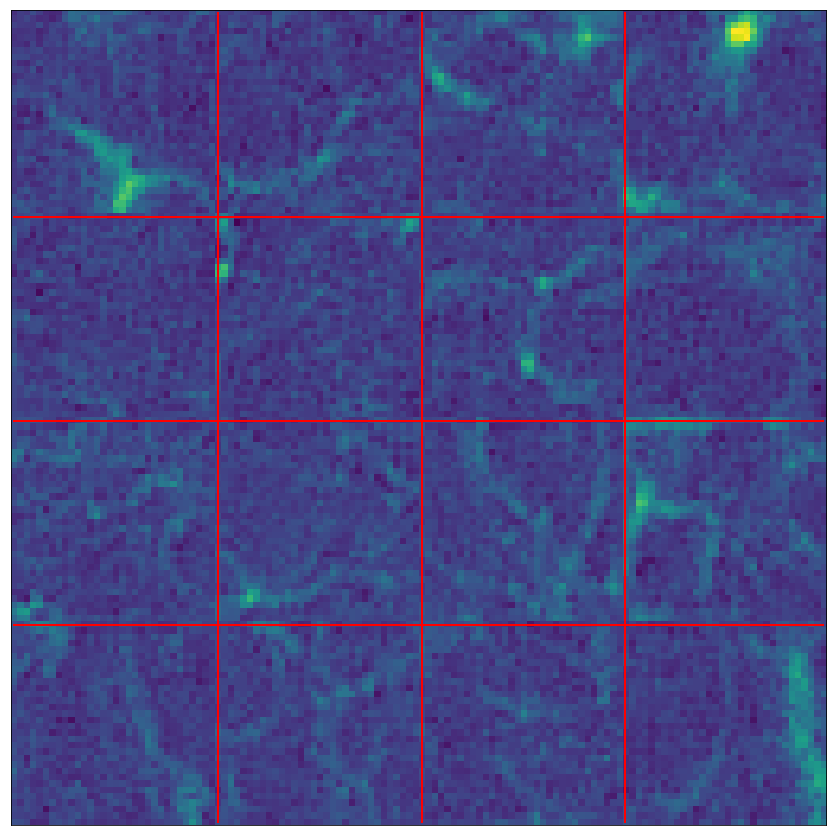

In [18]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [19]:
raw_images = backward(dataset.get_samples(dataset.N))

Log l2 PSD loss: 20.543457142104067
L2 PSD loss: 273441.2749702312
Log l1 PSD loss: 4.115879431618393
L1 PSD loss: 489.3086389128497


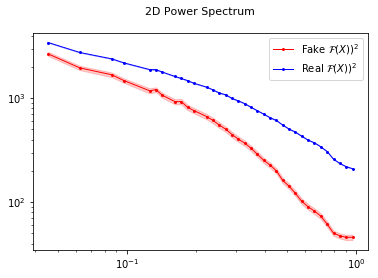

In [20]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 8.758016255696448
L2 Peak Count loss: 11.254568884251889
Log l1 Peak Count loss: 2.3281317594757
L1 Peak Count loss: 1.1689508666992188


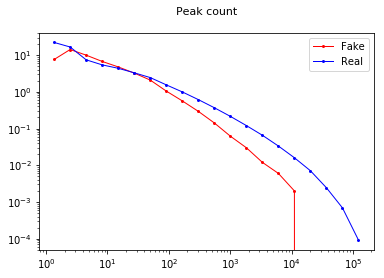

In [21]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 9.087466603231253
L2 Peak Mass histogram: 815.4685199757425
Log l1 Mass histogram loss: 2.187822633454467
L1 Mass histogram loss: 9.618038500976562


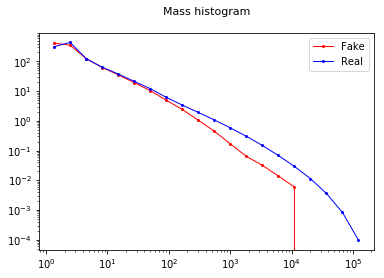

In [22]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)